### This notebook goes over how to access and load in CMIP6 data from the Google Cloud Storage (GCS), using full-depth ocean potential temperature model output from GFDL-ESM4.

__Author__: Dr. Beadling. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr 
import gcsfs 
import momlevel as ml
import cftime
import cmocean

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### The CMIP6 data stored in the Google Cloud Storage are derived from the original CMIP6 data files distributed via the Earth System Grid Federation (ESGF) (https://esgf-node.llnl.gov/projects/cmip6/).The CMIP6 hosted on Google Cloud are maintained by the Climate Data Science Lab at Lamont Doherty Earth Observatory (LDEO) of Columbia University, as part of the Pangeo Project .

### The CMIP6 dataset in Google Cloud Storage is publically available and free to use. 

### The code below reads in a `.csv` file that contains the CMIP6 data catalog stored in the Google Cloud. We can read this in as a __Pandas DataFrame__. 

In [3]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
google_cloud_cmip6

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
523769,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523770,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523771,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523772,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


### The CMIP6 data on Google Cloud is organized by the following:
* ### __activity_id__: The Model Intercomparison Project (MIP) activity. __CMIP__ is where the standard DECK experiments are (i.e., piControl, historical, 1pctCO2, etc). __ScenarioMIP__ is where the SSP scenario simulation output is.
* ### __institution_id__: The name of the institution or modeling center where the model comes from. A list of institution_ids can be found [here](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_institution_id.html) (Make sure to show 500 entries!)
* ### __source_id__: The name of the climate model. A table of all models participating in CMIP6 can be found [here](https://airtable.com/appYNLuWqAgzLbhSq/shrvRybShvNSE1Szp/tblC0DBPiCm7gjJqx).
* ### __experiment_id__: The climate model experiment name.
* ### __member_id__: The individual ensemble member.
* ### __table_id__: Specifying realm (atmosphere, ocean, ice, land, etc) and frequency of output (hourly, daily, monthly, annual ... etc): Click [here](https://docs.google.com/spreadsheets/d/1Hmu9fE9GdXUZoTl90vDv-qiI803L2feMxe6dAR0oErI/edit#gid=110419801) for a list and description of of all the possible __table ids__.
* ### __variable_id__: The name of the climate variables the models output. Some of these short names are very hard to discern unless you are very familiar with CMIP. Please see the table [here](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271) for all the possible variable names.
* ### __grid_label__: a key indicating if the model output is on the model's native grid or if regridded.
- grid_label = "gn" (output is reported on the native grid)
- grid_label = "gr" (output is not reported on the native grid, but instead is regridded by the modeling group)
- grid_label = “gm” (global mean output is reported, so data are not gridded)


* ### __z_store__: The path to the Zarr store where the data is stored.


## We can use the information above and Pandas' `.query()` method to filter through the CMIP6 archive to load in the Dataset we need:

In [5]:
url = "https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv"
cmip6_metadata = pd.read_csv(url)
unique_models = cmip6_metadata['source_id'].nunique()
print(f"Number of unique climate models contributing to CMIP6: {unique_models}")

Number of unique climate models contributing to CMIP6: 88


In [6]:
gfdl_esm4_thetao_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'thetao' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)

In [7]:
gfdl_esm4_thetao_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
12095,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701


## Great, so now that we have the Dataset we want ... how do we load it in?? We can load in the Zarr store that we've isolated above using `gcsfs`, `zarr`, and `xarray`.

In [8]:
gcs = gcsfs.GCSFileSystem(token='anon')

## The code below retrieves the path to a specific zarr store (the first one from the dataframe above)

In [9]:
zstore_esm4_thetao = gfdl_esm4_thetao_data.zstore.values[-1]

In [10]:
zstore_esm4_thetao

'gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Omon/thetao/gr/v20180701/'

## The code below creates a mutable-mapping-style interface to the zarra store and then loads in the Dataset using __xarray's__ `xr.open_zarr()` method. In the same line of code where we load in the Dataset we can also extract the array and rename some variables for consistency:

In [11]:
mapper_esm4_thetao = gcs.get_mapper(zstore_esm4_thetao)

gfdl_esm4_thetao = xr.open_zarr(mapper_esm4_thetao, 
                                consolidated=True,use_cftime=True).thetao.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_thetao

<xarray.DataArray 'thetao' (time: 1032, lev: 35, latitude: 180, longitude: 360)>
dask.array<open_dataset-thetao, shape=(1032, 35, 180, 360), dtype=float32, chunksize=(13, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

## Take a moment to become acquainted with DataArray you've just loaded in. <span style="color:red"> How many dimensions are there? What are their names? What are their coordinate labels? Then, in the code below, write code that would produce a plot of sea surface temperature for the first time slice ('2015-01-16').

There are 4 dimensions. These include time, lev, latitude, and longitude.

The coordinates are:
* Time: Ranges from 2015-01-16 12:00:00 to 2100-12-16 12:00:00 with 1032 entries (monthly data for 86 years).
* Lev: 35 depth levels ranging from 2.5 meters to 6500 meters.
* Latitude: 180 points ranging from -89.5 degrees (south pole) to 89.5 degrees (north pole).
* Longitude: 360 points ranging from 0.5 degrees to 359.5 degrees.

In [86]:
print(gfdl_esm4_thetao.dims)  
print(gfdl_esm4_thetao.coords)  
print(gfdl_esm4_thetao)  

('time', 'lev', 'latitude', 'longitude')
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
<xarray.DataArray 'thetao' (time: 1032, lev: 35, latitude: 180, longitude: 360)>
dask.array<open_dataset-thetao, shape=(1032, 35, 180, 360), dtype=float32, chunksize=(13, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where se

In [61]:
print(gfdl_esm4_thetao['lev'].values)

[2.5000e+00 1.0000e+01 2.0000e+01 3.2500e+01 5.1250e+01 7.5000e+01
 1.0000e+02 1.2500e+02 1.5625e+02 2.0000e+02 2.5000e+02 3.1250e+02
 4.0000e+02 5.0000e+02 6.0000e+02 7.0000e+02 8.0000e+02 9.0000e+02
 1.0000e+03 1.1000e+03 1.2000e+03 1.3000e+03 1.4000e+03 1.5375e+03
 1.7500e+03 2.0625e+03 2.5000e+03 3.0000e+03 3.5000e+03 4.0000e+03
 4.5000e+03 5.0000e+03 5.5000e+03 6.0000e+03 6.5000e+03]


In [87]:
sst_2015 = gfdl_esm4_thetao.sel(time='2015-01-16', lev=2.5)

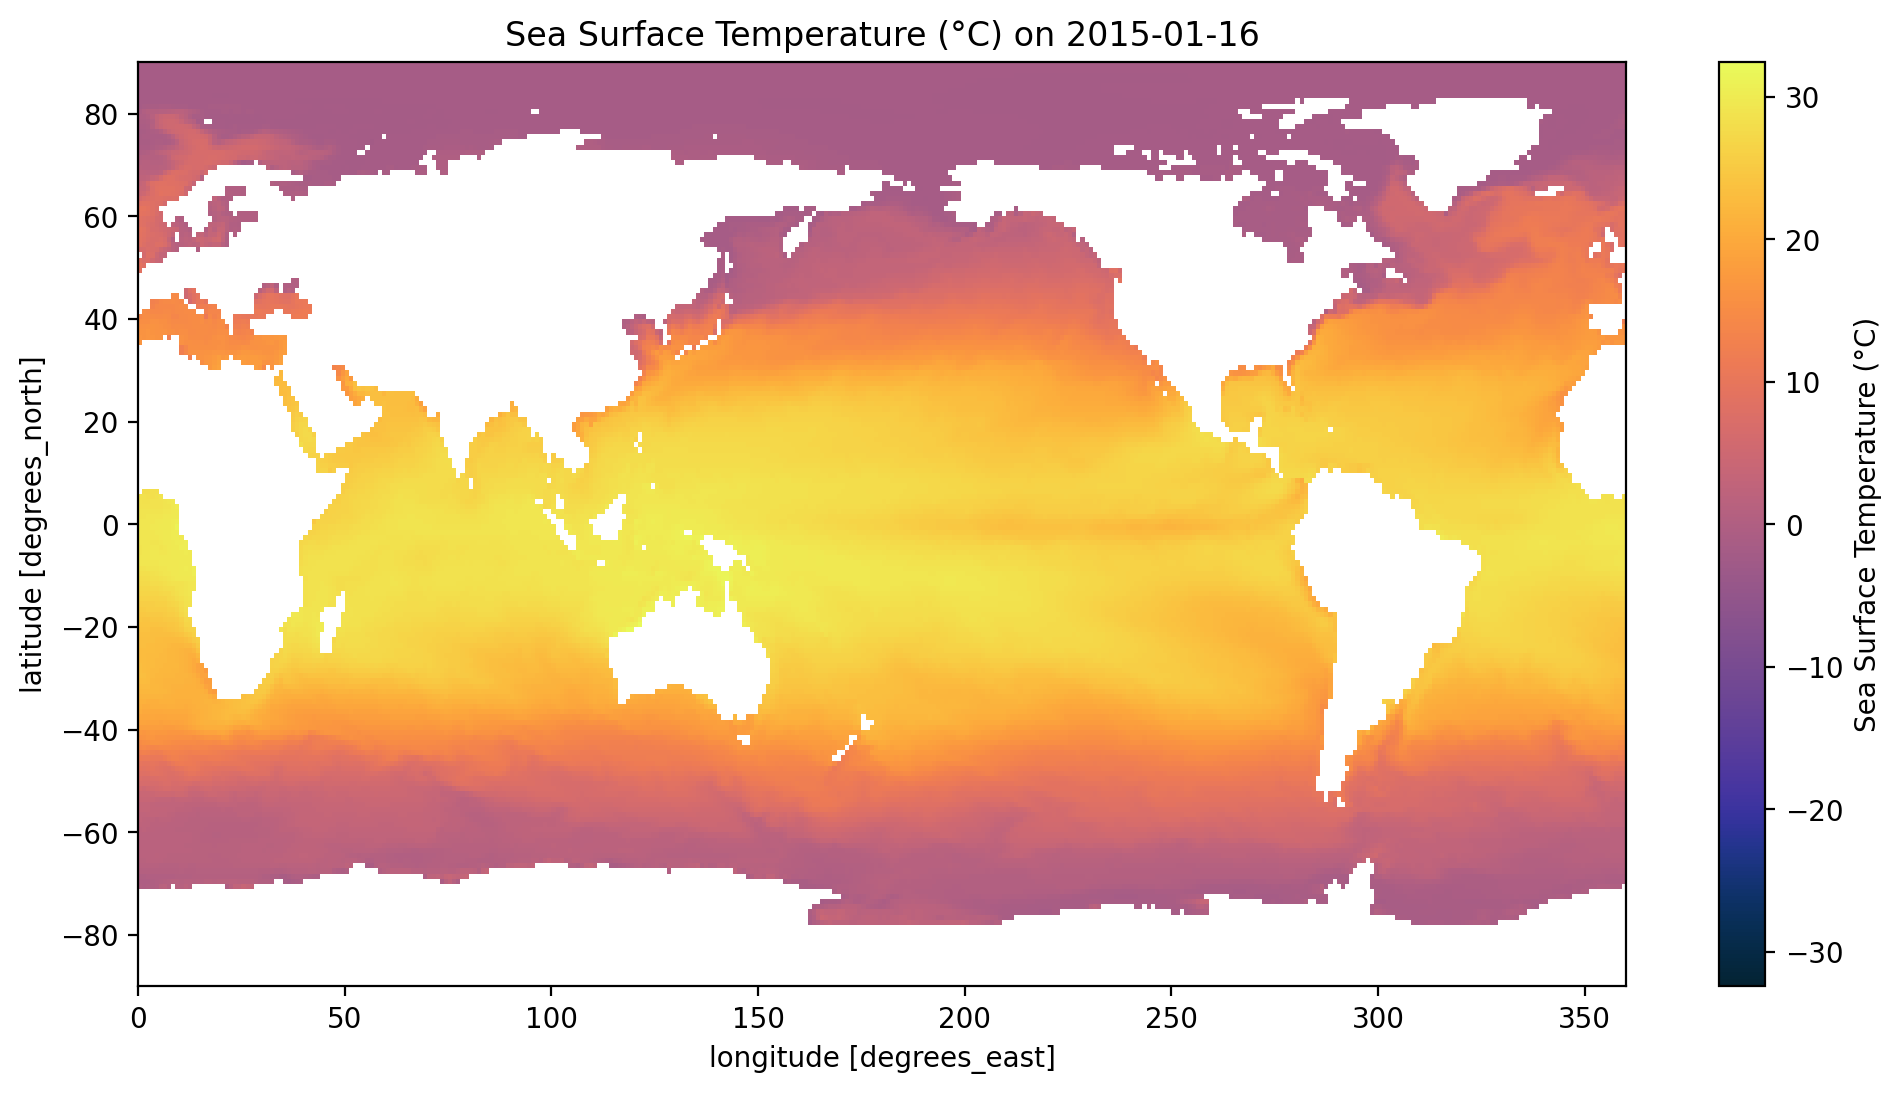

In [88]:
sst_2015.plot(
    cmap=cmocean.cm.thermal,
    figsize=(12, 6),
    cbar_kwargs={'label': 'Sea Surface Temperature (°C)'}
)
plt.title('Sea Surface Temperature (°C) on 2015-01-16')
plt.show()

## <span style="color:red"> Okay, now write code in the cell below that produces a time-average of the full-depth data spanning years 2015 to 2025 and a time-average of years 2081 to 2100 (**hint .... you've already done this in a previous project).

In [89]:
time_avg_2015_2025 = gfdl_esm4_thetao.sel(time=slice('2015-01-01', '2025-12-31')).mean(dim='time')
time_avg_2081_2100 = gfdl_esm4_thetao.sel(time=slice('2081-01-01', '2100-12-31')).mean(dim='time')

print(time_avg_2015_2025)
print(time_avg_2081_2100)

<xarray.DataArray 'thetao' (lev: 35, latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(35, 180, 360), dtype=float32, chunksize=(35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
<xarray.DataArray 'thetao' (lev: 35, latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(35, 180, 360), dtype=float32, chunksize=(35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5


## <span style="color:red"> Okay, now compute the difference as last period minus first period:

In [90]:
thetao_2015_2025 = gfdl_esm4_thetao.sel(time=slice('2015-01-01', '2025-12-31')).mean(dim='time')
thetao_2081_2100 = gfdl_esm4_thetao.sel(time=slice('2081-01-01', '2100-12-31')).mean(dim='time')

thetao_diff = thetao_2081_2100 - thetao_2015_2025
print(thetao_diff)

<xarray.DataArray 'thetao' (lev: 35, latitude: 180, longitude: 360)>
dask.array<sub, shape=(35, 180, 360), dtype=float32, chunksize=(35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5


In [91]:
print(thetao_diff)

<xarray.DataArray 'thetao' (lev: 35, latitude: 180, longitude: 360)>
dask.array<sub, shape=(35, 180, 360), dtype=float32, chunksize=(35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5


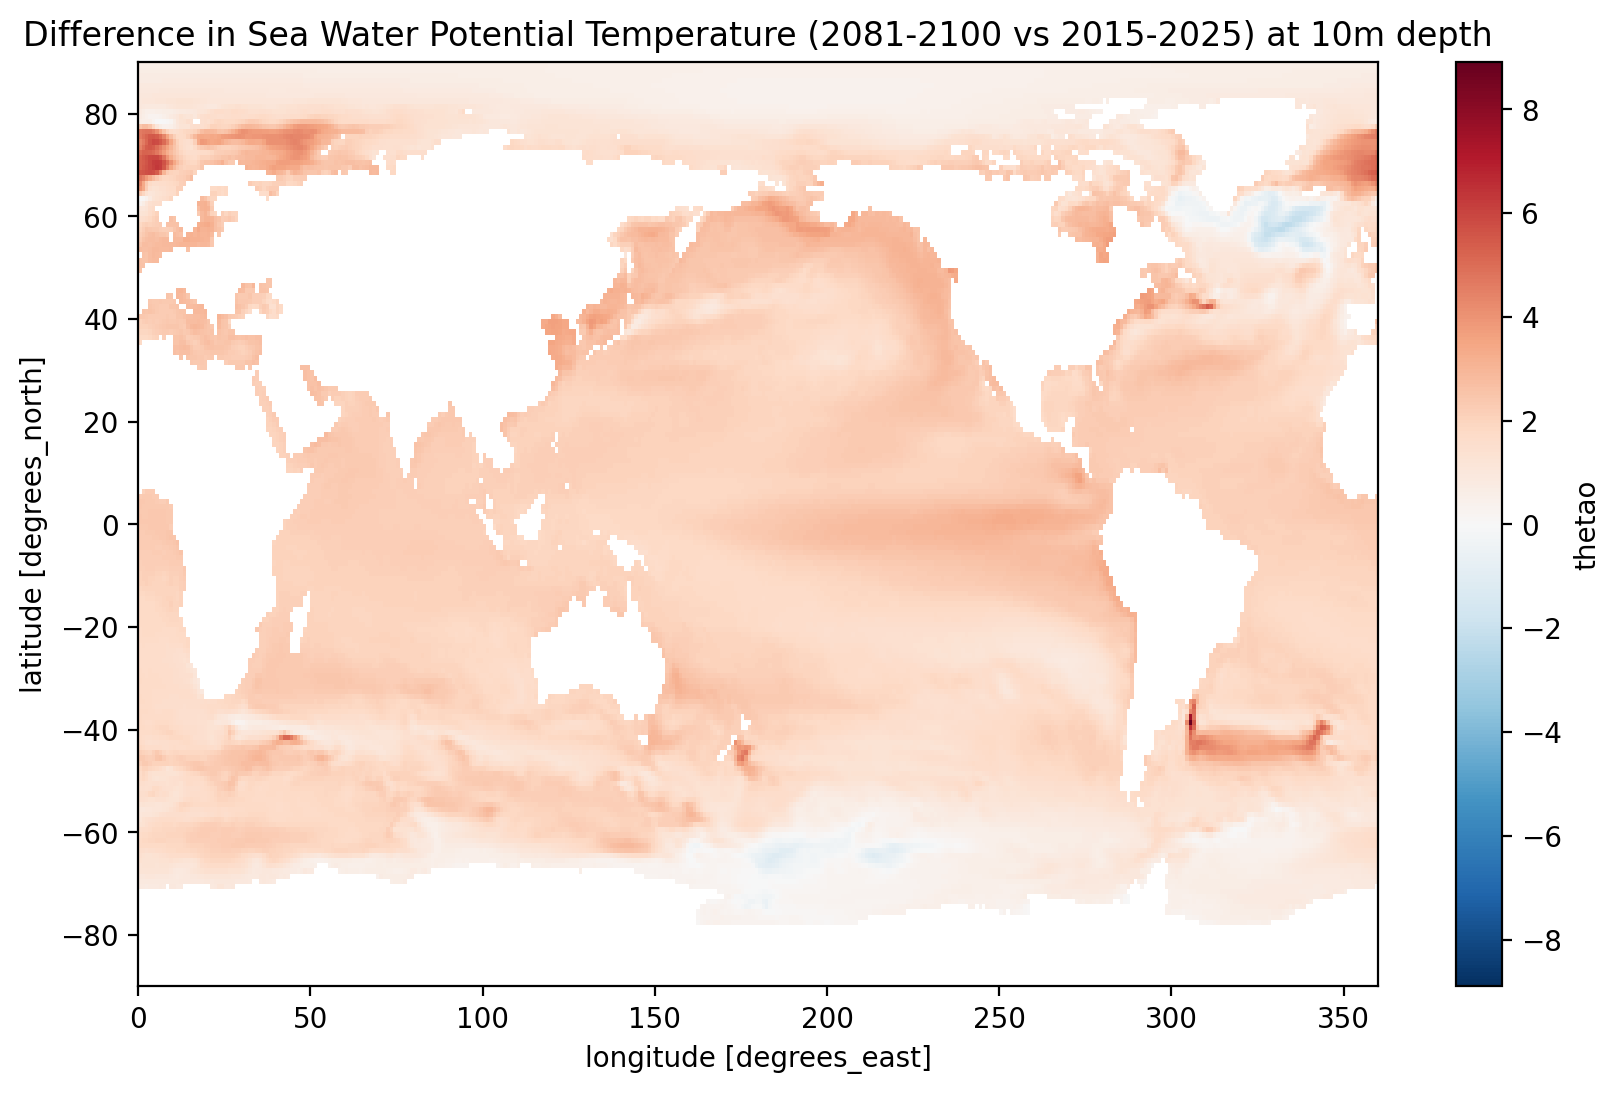

In [92]:
thetao_diff_10m = thetao_diff.sel(lev=10.0)

plt.figure(figsize=(10, 6))
thetao_diff_10m.plot()
plt.title("Difference in Sea Water Potential Temperature (2081-2100 vs 2015-2025) at 10m depth")
plt.show()

In [93]:
print(thetao_diff.min())
print(thetao_diff.max())

<xarray.DataArray 'thetao' ()>
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
<xarray.DataArray 'thetao' ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


In [69]:
# Compute min and max, ignoring NaNs
min_value = thetao_diff.min(skipna=True)
max_value = thetao_diff.max(skipna=True)

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: <xarray.DataArray 'thetao' ()>
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Maximum value: <xarray.DataArray 'thetao' ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


In [94]:
print(thetao_diff)

<xarray.DataArray 'thetao' (lev: 35, latitude: 180, longitude: 360)>
dask.array<sub, shape=(35, 180, 360), dtype=float32, chunksize=(35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5


### Examining your surface plot above tells you that our longitudes span 0 to 360, so if we want 24 W, this is equivalent to 360 - 24 = 336. <span style="color:red"> Knowing this, write code in the cell below that plots the difference in ocean temperature along longitude=336 using `.sel(longitude=336, method='nearest')` and using the cmocean.cm.balance colormap:

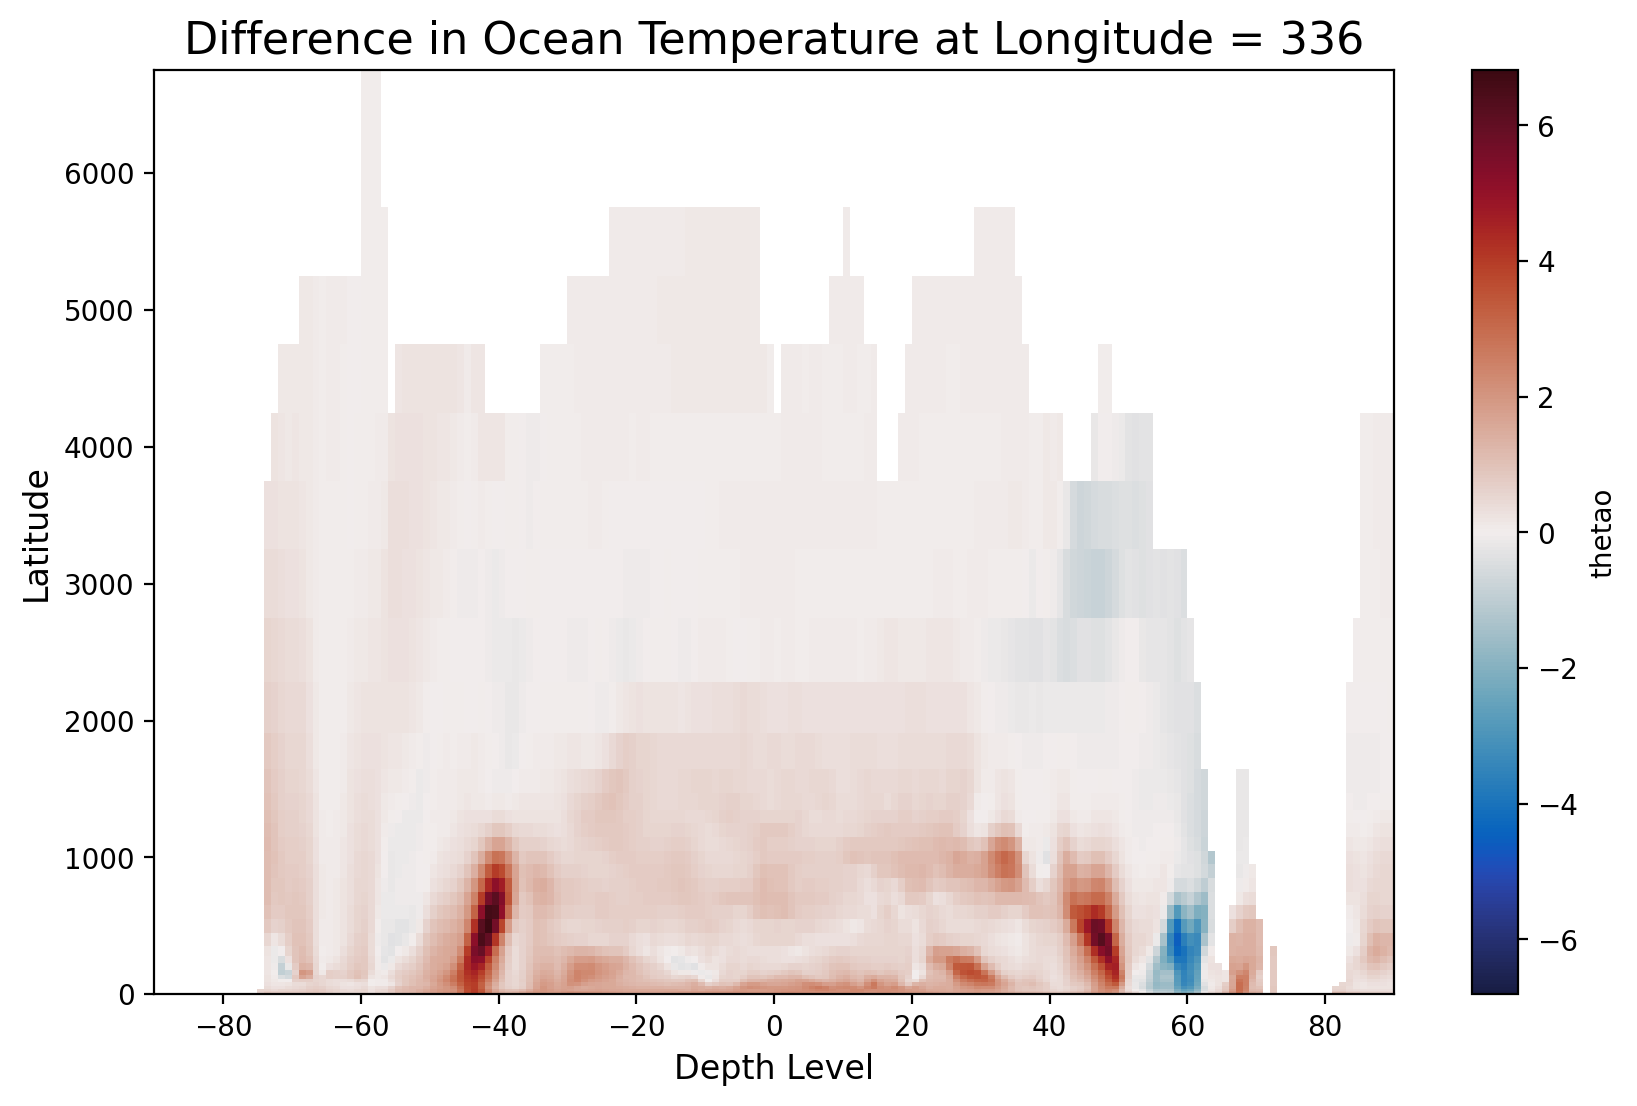

In [95]:
thetao_diff_longitude = thetao_diff.sel(longitude=336, method='nearest')
plt.figure(figsize=(10, 6))
thetao_diff_longitude.plot(cmap=cmocean.cm.balance)
plt.title('Difference in Ocean Temperature at Longitude = 336', fontsize=16)
plt.xlabel('Depth Level', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

### <span style="color:red"> Repeat the steps above, but instead of plotting the temperature difference along a specific transect, plot the __full zonal average__.

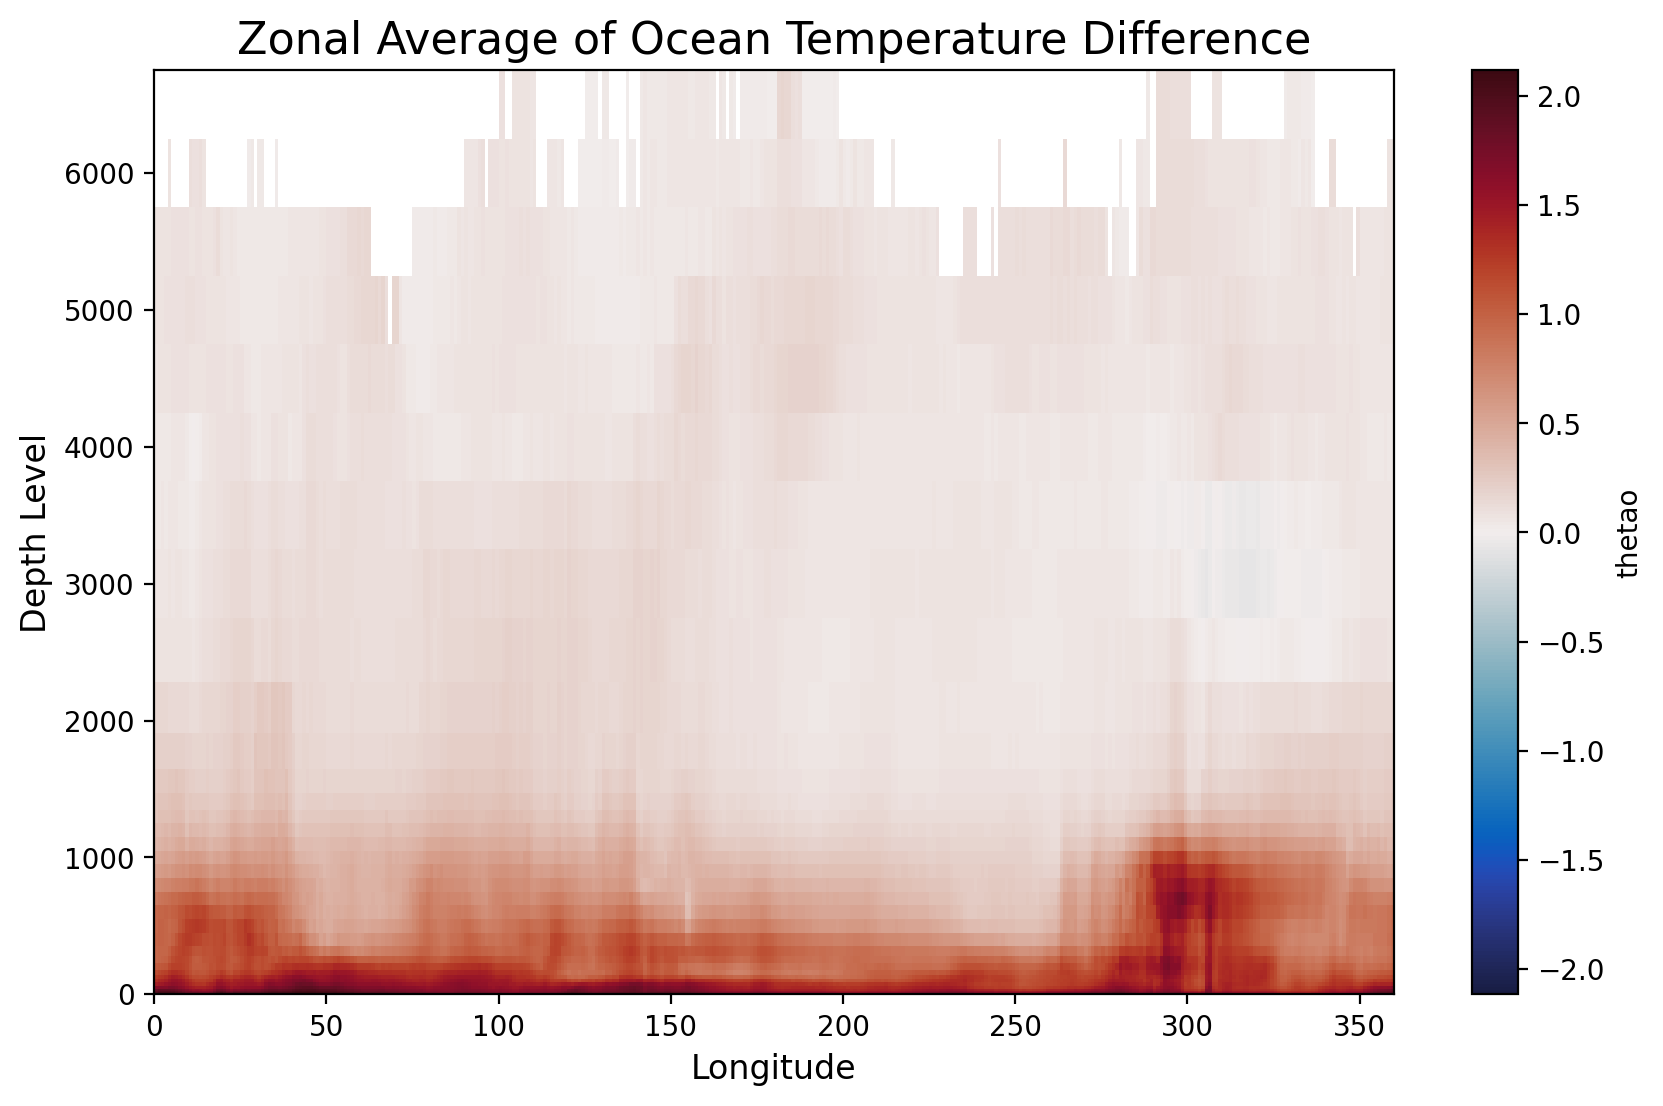

In [96]:
thetao_diff_zonal_avg = thetao_diff.mean(dim='latitude')
plt.figure(figsize=(10, 6))
thetao_diff_zonal_avg.plot(cmap=cmocean.cm.balance)
plt.title('Zonal Average of Ocean Temperature Difference', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Depth Level', fontsize=12)
plt.show()

### The following code produces a plot of the zonally-averaged ocean temperature over the first 20 years,  and the difference.

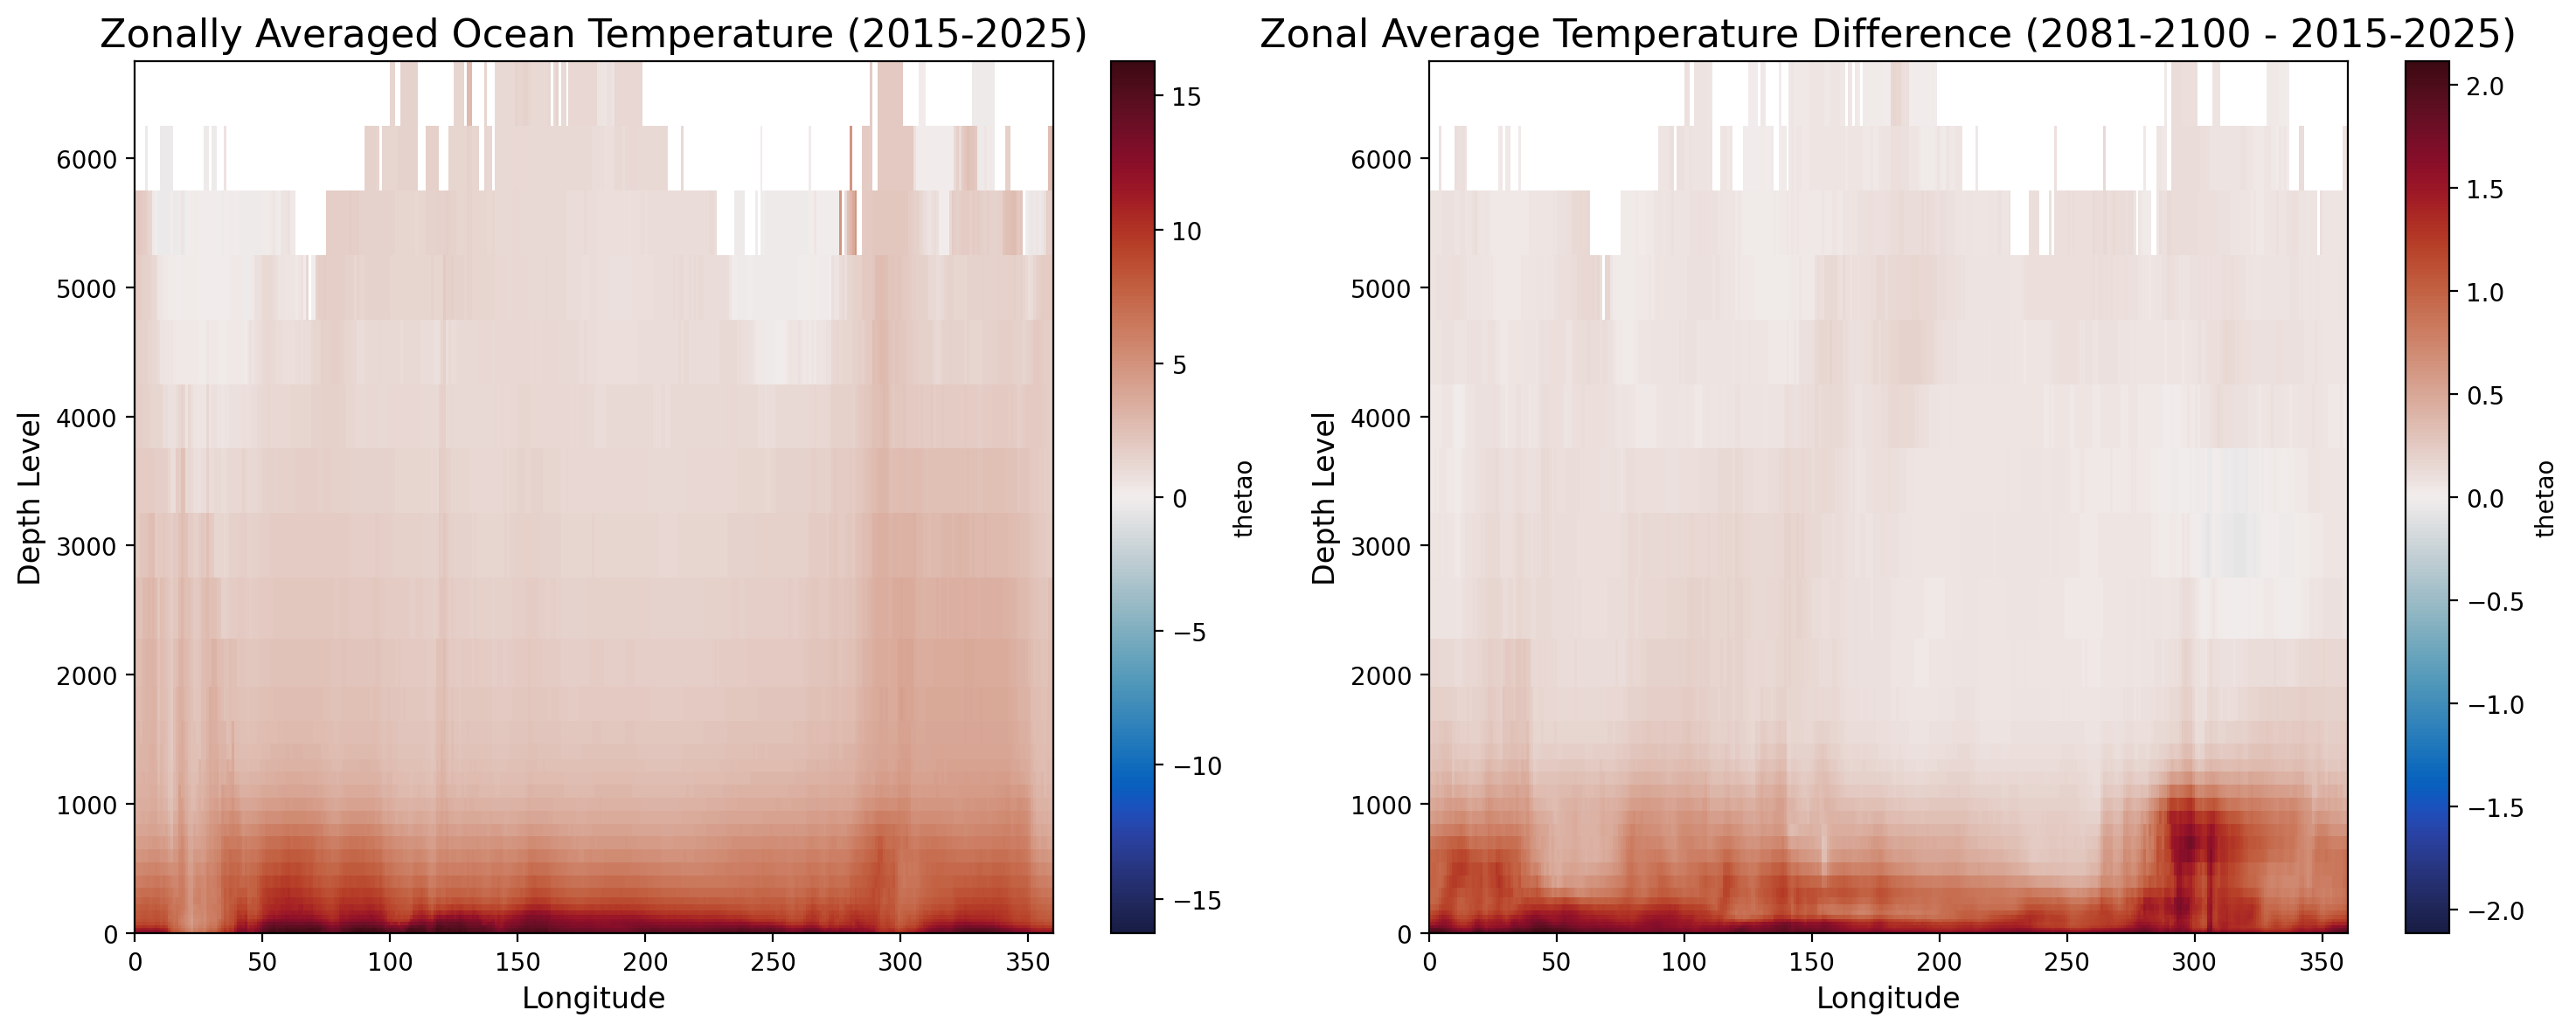

In [97]:
thetao_2015_2025_zonal_avg = thetao_2015_2025.mean(dim='latitude')
thetao_diff_zonal_avg = thetao_diff.mean(dim='latitude')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
thetao_2015_2025_zonal_avg.plot(ax=axes[0], cmap=cmocean.cm.balance)
axes[0].set_title('Zonally Averaged Ocean Temperature (2015-2025)', fontsize=16)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Depth Level', fontsize=12)
thetao_diff_zonal_avg.plot(ax=axes[1], cmap=cmocean.cm.balance)
axes[1].set_title('Zonal Average Temperature Difference (2081-2100 - 2015-2025)', fontsize=16)
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Depth Level', fontsize=12)
plt.tight_layout()
plt.show()

### <span style="color:red"> In the cells below, describe how the zonally-averaged distribution of temperature changes from the end of the century relative to the start. Where does most of the heat uptake occur?

By the end of the century (2081-2100), the zonally-averaged ocean temperature shows a noticeable increase, especially at the surface in tropical and high-latitude regions. The most significant warming occurs in the upper ocean, with tropical and subtropical regions, as well as polar areas, experiencing the highest temperature rises. While the surface warms more rapidly, the deeper layers also see gradual temperature increases, though less pronounced.

The majority of the heat uptake happens in the Southern Ocean and tropical Pacific. The Southern Ocean absorbs significant heat, while tropical regions experience both surface warming and heat redistribution through ocean currents. This heat uptake affects ocean stratification and circulation, potentially influencing climate patterns and marine ecosystems. The overall warming at the surface, coupled with deeper ocean changes, will have widespread effects on global ocean dynamics and ecosystems.

### The following code is modified from above to now read in ssp245 data (medium emission scenario)

In [98]:
gfdl_esm4_thetao_data_ssp245 = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'thetao' & \
    experiment_id == 'ssp245' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)

zstore_esm4_thetao_ssp245 = gfdl_esm4_thetao_data_ssp245.zstore.values[-1]
mapper_esm4_thetao_ssp245 = gcs.get_mapper(zstore_esm4_thetao_ssp245)
gfdl_esm4_thetao_ssp245 = xr.open_zarr(mapper_esm4_thetao_ssp245, 
                                consolidated=True,use_cftime=True).thetao.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_thetao_ssp245

<xarray.DataArray 'thetao' (time: 1032, lev: 35, latitude: 180, longitude: 360)>
dask.array<open_dataset-thetao, shape=(1032, 35, 180, 360), dtype=float32, chunksize=(13, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Water Potential Temperature
    original_name:  thetao
    standard_name:  sea_water_potential_temperature
    units:          degC

### <span style="color:red"> Repeat the excercise above: Compute the difference in zonally-averaged ocean temperature as the last-twenty year average minus the first. How does this differ to the plot you created above for the SSP585 scenario?

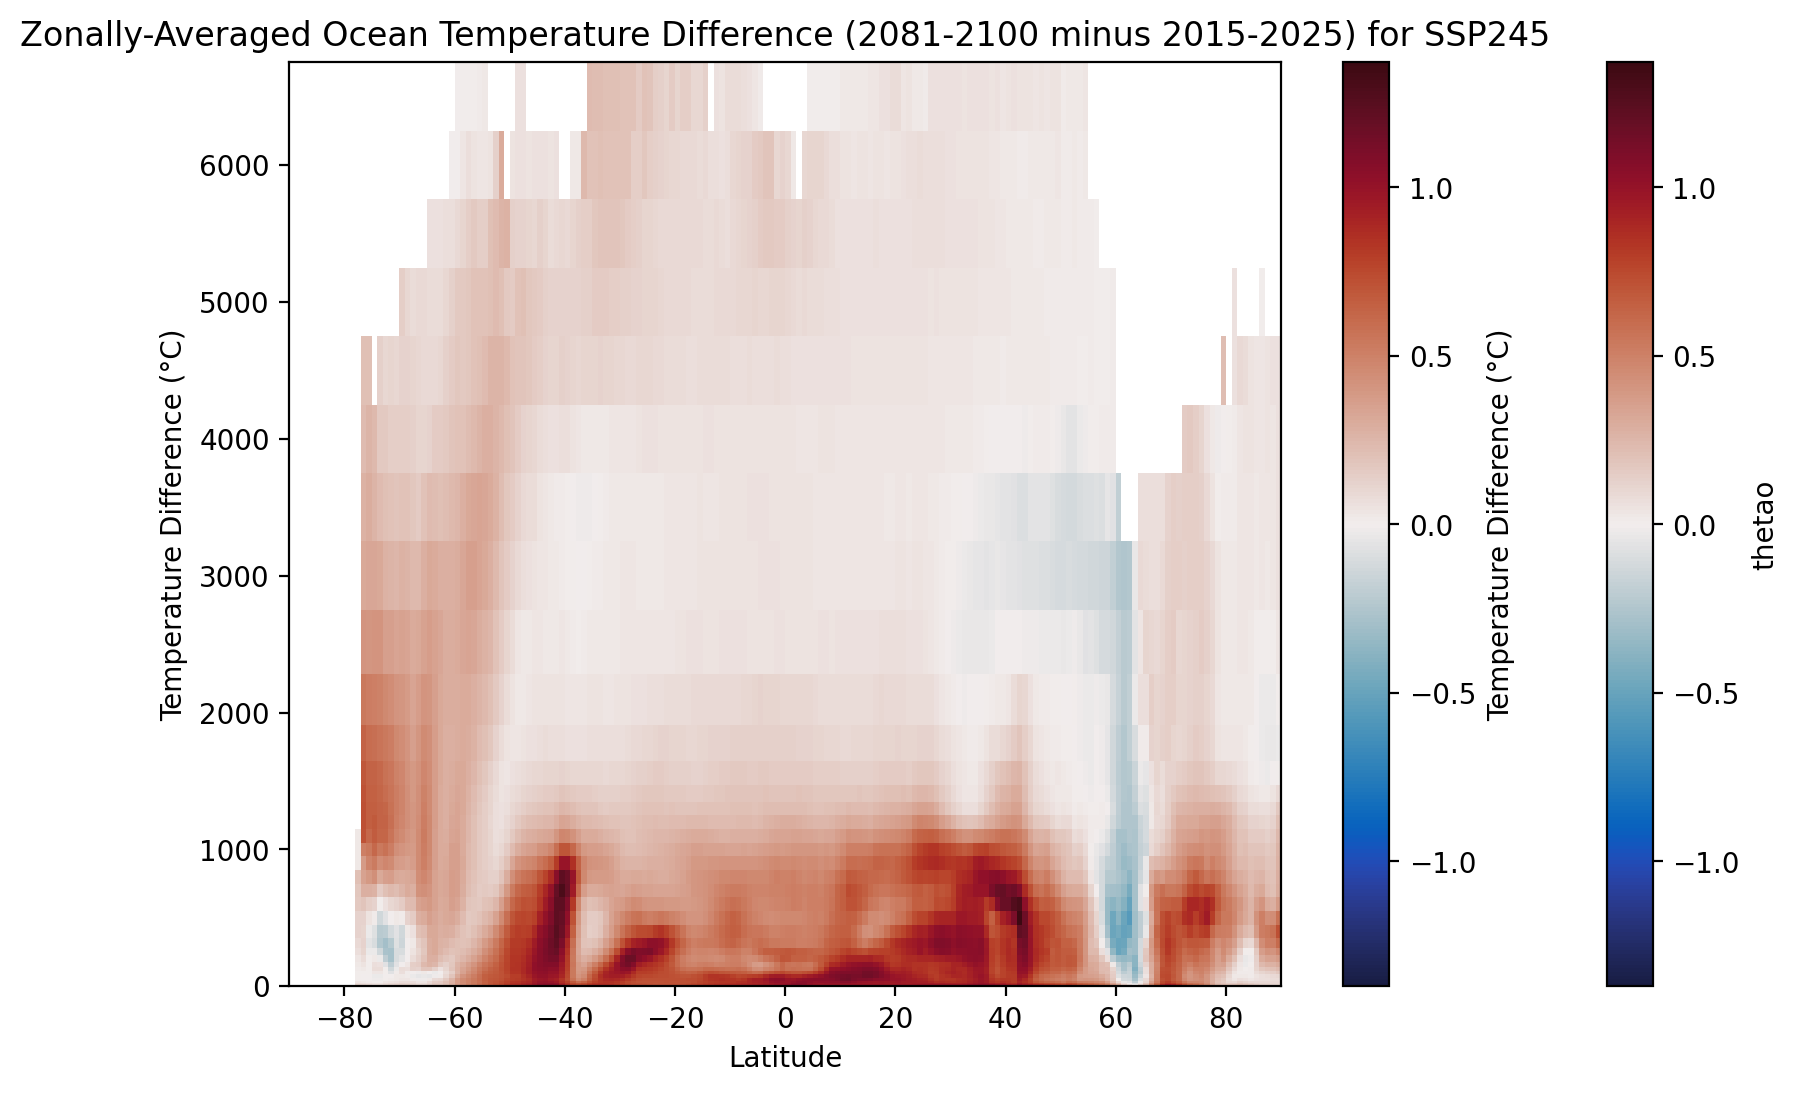

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
c = thetao_diff_zonal_avg_ssp245.plot(ax=ax, cmap='cmo.balance')
fig.colorbar(c, ax=ax, label='Temperature Difference (°C)')
ax.set_title('Zonally-Averaged Ocean Temperature Difference (2081-2100 minus 2015-2025) for SSP245')
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature Difference (°C)')
plt.show()

For the SSP245 scenario, which represents a moderate emissions pathway, the difference in zonally-averaged ocean temperatures between the 2081-2100 and 2015-2025 periods is smaller compared to the SSP585 scenario. In SSP245, the warming trend is more gradual, particularly in the tropics and subtropics, with less pronounced temperature increases at higher latitudes. The warming is relatively uniform across latitudes, especially in the deeper ocean layers. On the other hand, the SSP585 scenario, which assumes a higher emissions pathway, results in more intense warming, particularly at high latitudes, such as the Arctic, where rapid warming is more evident. This leads to a sharper temperature difference in SSP585, especially near the poles, whereas in SSP245, the warming is more moderate and less concentrated at the poles, leading to a more even zonal temperature difference across the globe.